## Run each cell sequeuntially, in order going down. If a vocab and embedding have already been made, then you can load from that filepath. Labelled where appropriate

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments,RobertaTokenizer,RobertaForSequenceClassification
from torch.utils.data import Dataset
import torch
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import roc_auc_score
import pickle
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score, confusion_matrix
from torch.optim import AdamW
import matplotlib.pyplot as plt
from sklearn import metrics


In [3]:
#paths to the csvs
train_path = '/content/drive/MyDrive/NLI/train.csv'
dev_path = '/content/drive/MyDrive/NLI/dev.csv'
glove_path = '/content/drive/MyDrive/NLI/glove.840B.300d.txt'

In [4]:
device = "cuda"

## Skip the next 3 cells if you have already run them or have the pickle file

In [5]:
#building the vocab, giving each word an index, don't add infrequent words
def build_vocab(csv, min_freq=2):
    counter = {}
    combined = csv['premise'].tolist() + csv['hypothesis'].tolist()
    for text in combined:
        words = text.lower().split()
        for word in words:
            if word not in counter:
                counter[word] = 1
            else:
                counter[word] += 1

    word2idx = {'<unk>': 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            word2idx[word] = len(word2idx)
    return word2idx
train_set = pd.read_csv(train_path)
word2idx = build_vocab(train_set)

In [6]:
#glove embeddings loaded from path with the word to indexes
def load_glove_embeddings(glove_path, word2idx, embed_dim=300):
    #matrix created with (vocab size + 1, embedding dimensions) with random valeus as detailed in the paper
    embeddings = np.random.normal(scale=0.6, size=(len(word2idx) + 1, embed_dim))
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.rstrip().split(' ')
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            #if a word has an embedding, the corresponding row is replaced with the glove vector
            if word in word2idx:
                idx = word2idx[word]
                embeddings[idx] = vector
    return embeddings

final_embeddings = load_glove_embeddings(glove_path, word2idx)

In [7]:
#saving and loading of the embeddings and word indexes
with open('/content/drive/MyDrive/NLI/vocab_and_glove_new.pkl', 'wb') as f:
    pickle.dump((word2idx, final_embeddings), f)


## Load if already run

In [5]:
with open('/content/drive/MyDrive/NLI/vocab_and_glove_new.pkl', 'rb') as f:
    word2idx, final_embeddings = pickle.load(f)

In [ ]:
#Used code for model from: https://github.com/dunesand/Text-Matching-based-on-ESIM-model/blob/master/esim_model.py , parts throughout, but the soft-attention implementation was used most
# Model proposed is a new model inspired from the ESIM model that got higher accuracies than base ESIM model
#Papers: Use of element-wise features: https://arxiv.org/pdf/1609.06038v3 Soft-attention alignment: https://arxiv.org/pdf/1509.06664 Residual connections used in NLI task: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9170272 Idea for gated mechanism (computed in a different way though): https://arxiv.org/pdf/1708.01353

## ESIM model


In [6]:
class ESIM(nn.Module):
    def __init__(self, hidden_size, embed_dim, linear_size, embedding_matrix, dropout=0.5):
        super().__init__()
        self.hidden_size = hidden_size
        self.embed_dim = embed_dim
        self.dropout_rate = dropout

        #embedding layer with embedding matrix created.
        num_words = embedding_matrix.shape[0] - 1
        self.embedding = nn.Embedding(num_words + 1, embed_dim, padding_idx=0)
        self.embedding.weight = nn.Parameter(torch.from_numpy(embedding_matrix).float(), requires_grad=True)
        self.embed_dropout = nn.Dropout(dropout)
        self.bn_embedding = nn.BatchNorm1d(embed_dim)

        #biLSTM encoder
        self.lstm1 = nn.LSTM(embed_dim, hidden_size, batch_first=True, bidirectional=True)

        #contextual encoding enhanced using self-attention
        self.self_attention = nn.MultiheadAttention(embed_dim=2 * hidden_size, num_heads=4, batch_first=True)

        #2 layer biLSTM used with dropout for regularisation
        self.lstm2 = nn.LSTM(hidden_size * 8, hidden_size, num_layers=2, batch_first=True,
                             bidirectional=True, dropout=dropout)
        # projection to match dimensions input is 8*hidden_size, output is 2*hidden_size.
        self.residual_proj = nn.Linear(hidden_size * 8, 2 * hidden_size)

        #gating layer is used to modulate the new representations
        self.attention_gate = nn.Linear(2 * hidden_size, 2 * hidden_size)

        #final classifier that takes [o1_rep, o2_rep, diff, prod] (16*hidden_size).
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(16 * hidden_size),
            nn.Linear(16 * hidden_size, linear_size),
            nn.ELU(inplace=True),
            nn.BatchNorm1d(linear_size),
            nn.Dropout(dropout),
            nn.Linear(linear_size, linear_size),
            nn.ELU(inplace=True),
            nn.BatchNorm1d(linear_size),
            nn.Dropout(dropout),
            nn.Linear(linear_size, 1)
        )

        #mask value
        self.mask_val = -2**32 + 1.0

    def forward(self, sent1, sent2):
        #masks where tokens = 0
        mask1 = sent1.eq(0)
        mask2 = sent2.eq(0)

        #embedding shape = (batch, seq_len, embed_dim), dropout, and batch normalisation.
        x1 = self.embed_dropout(self.embedding(sent1))
        x2 = self.embed_dropout(self.embedding(sent2))
        x1 = self.bn_embedding(x1.transpose(1, 2)).transpose(1, 2)
        x2 = self.bn_embedding(x2.transpose(1, 2)).transpose(1, 2)

        #first biLSTM encoding with shape = (batch, seq_len, 2*hidden_size)
        o1, _ = self.lstm1(x1)
        o2, _ = self.lstm1(x2)

        #self-attention is applied
        o1_sa, _ = self.self_attention(o1, o1, o1)
        o2_sa, _ = self.self_attention(o2, o2, o2)
        o1 = o1 + o1_sa
        o2 = o2 + o2_sa

        #soft-attention alignments
        o1_aligned, o2_aligned = self.soft_attention_align(o1, o2, mask1, mask2)

        #gating applied
        gate1 = torch.sigmoid(self.attention_gate(o1))
        gate2 = torch.sigmoid(self.attention_gate(o2))
        o1_aligned = o1_aligned * gate1
        o2_aligned = o2_aligned * gate2

        #original and aligned representation concatenated with element-wise subtractions and multiplication
        o1_combined = torch.cat([o1, o1_aligned, self.submul(o1, o1_aligned)], dim=-1)
        o2_combined = torch.cat([o2, o2_aligned, self.submul(o2, o2_aligned)], dim=-1)

        #representations using the deeper LSTM
        o1_composed, _ = self.lstm2(o1_combined)
        #residual connections used to preserve lower level features
        o1_composed = o1_composed + self.residual_proj(o1_combined)

        o2_composed, _ = self.lstm2(o2_combined)
        o2_composed = o2_composed + self.residual_proj(o2_combined)

        #pooling on the aggregate representations, both with shape = (batch, 4*hidden_size)
        o1_rep = self.apply_pooling(o1_composed)
        o2_rep = self.apply_pooling(o2_composed)

        #absolute difference and element-wise features captured for additional pair features
        diff = torch.abs(o1_rep - o2_rep)
        prod = o1_rep * o2_rep

        #features concatenated with shape = (batch, 16*hidden_size)
        combined_rep = torch.cat([o1_rep, o2_rep, diff, prod], dim=-1)

        # Final classification.
        similarity = self.classifier(combined_rep)
        return similarity

    def soft_attention_align(self, x1, x2, mask1, mask2):
        #attention scores computed
        attention_scores = torch.matmul(x1, x2.transpose(1, 2))

        #masks then applied to attention scores
        mask1_val = mask1.float().masked_fill(mask1, self.mask_val)
        mask2_val = mask2.float().masked_fill(mask2, self.mask_val)

        #compute soft alignment weights and produce aligned representations.
        weight1 = F.softmax(attention_scores + mask2_val.unsqueeze(1), dim=-1)
        aligned_x1 = torch.matmul(weight1, x2)
        weight2 = F.softmax(attention_scores.transpose(1, 2) + mask1_val.unsqueeze(1), dim=-1)
        aligned_x2 = torch.matmul(weight2, x1)
        return aligned_x1, aligned_x2

    def submul(self, x1, x2):
        #element-wise subtractions and multiplication
        subtraction = x1 - x2
        multiplication = x1 * x2
        return torch.cat([subtraction, multiplication], dim=-1)

    def apply_pooling(self, x):
        #average and max pooling
        avg_pooled = F.avg_pool1d(x.transpose(1, 2), kernel_size=x.size(1)).squeeze(-1)
        max_pooled = F.max_pool1d(x.transpose(1, 2), kernel_size=x.size(1)).squeeze(-1)
        return torch.cat([avg_pooled, max_pooled], dim=-1)


## Dataloading and model loading

In [7]:
#dataset reads the csv from filepath and returns the tokenised, indexed tensors of sentence pairs with the label
class NliDataset(Dataset):
    def __init__(self, filepath, word2idx, max_len=64):
        self.data = pd.read_csv(filepath)
        self.word2idx = word2idx
        self.max_len = max_len

    def encode(self, sentence):
        tokens = sentence.lower().split()
        #for each token, look up the index in vocab, if it isn't found replace it with unk
        ids = [self.word2idx.get(tok, self.word2idx['<unk>']) for tok in tokens]
        #truncates to 64
        return torch.tensor(ids[:self.max_len], dtype=torch.long)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        sent1 = self.encode(row['premise'])
        sent2 = self.encode(row['hypothesis'])
        label = float(row['label'])
        return sent1, sent2, label

    def __len__(self):
        return len(self.data)

def collate_fn(batch):
    #combines multiple samples into a batch, padding applied for consistent lengths
    s1, s2, labels = zip(*batch)
    s1 = pad_sequence(s1, batch_first=True, padding_value=0)
    s2 = pad_sequence(s2, batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.float)
    return s1, s2, labels

In [8]:
#model loading, dataset loading too.
model = ESIM(hidden_size=300, embed_dim=300, linear_size=512, embedding_matrix=final_embeddings).to(device)

In [9]:
train_dataset = NliDataset(train_path, word2idx)
val_dataset = NliDataset(dev_path, word2idx)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [11]:
#optimiser called with the parameters needed, used 0.0002 and 0 wd
#since its binary classifications, logits used
loss_fn = nn.BCEWithLogitsLoss()
optimiser = AdamW(model.parameters(), lr=0.0002, weight_decay=0.00000)



## Training and evaluation loop

In [14]:
def evaluate(model, val_loader, device, loss_fn):
    #calculate all validation matrics and loss to ensure no overfitting
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for sent1, sent2, labels in val_loader:
            sent1 = sent1.to(device)
            sent2 = sent2.to(device)
            labels = labels.to(device)

            logits = model(sent1, sent2)
            logits = logits.squeeze(-1)
            probs = torch.sigmoid(logits)

            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    binary_preds = [1 if p >= 0.5 else 0 for p in all_preds]

    val_acc = accuracy_score(all_labels, binary_preds)
    val_auc = roc_auc_score(all_labels, all_preds)
    val_loss = total_loss / len(val_loader)

    precision = precision_score(all_labels, binary_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, binary_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, binary_preds, average='macro', zero_division=0)
    mcc = matthews_corrcoef(all_labels, binary_preds)

    return val_acc, val_auc, val_loss, precision, recall, f1, mcc

In [77]:
def train(model, train_loader, val_loader, optimiser, loss_fn, device, epochs=3):
    best_acc = 0

    for epoch in range(epochs):
        #for each epoch, set the model to training mode, calculate loss for that epoch and predictions and labels
        #for each batch:
        #    -Move inputs and labels to the correct device (CPU/GPU)
        #    -Forward pass to get model predictions (logits)
        #    -Compute loss using the provided loss function
        #    -Zero out previous gradients
        #    -Backpropagate to compute gradients
        #    -Update model parameters using the optimiser
        #    -Collect loss and predictions for monitoring
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for sent1, sent2, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            sent1 = sent1.to(device)
            sent2 = sent2.to(device)
            labels = labels.to(device)

            logits = model(sent1, sent2)
            logits = logits.squeeze(-1)
            loss = loss_fn(logits, labels)

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            total_loss += loss.item()

            probs = torch.sigmoid(logits).detach().cpu().numpy()
            all_preds.extend(probs)
            all_labels.extend(labels.cpu().numpy())

        binary_preds = [1 if p >= 0.5 else 0 for p in all_preds]
        train_auc = roc_auc_score(all_labels, all_preds)
        train_acc = accuracy_score(all_labels, binary_preds)
        train_loss = total_loss / len(train_loader)

        val_acc, val_auc, val_loss, _, _, _, _ = evaluate(model, val_loader, device, loss_fn)

        print(
            "Epoch", epoch + 1, "|",
            "Train Loss:", round(train_loss, 4), "|",
            "Train Acc:", round(train_acc, 4), "|",
            "Train AUC:", round(train_auc, 4), "|",
            "Val Loss:", round(val_loss, 4), "|",
            "Val Acc:", round(val_acc, 4), "|",
            "Val AUC:", round(val_auc, 4)
        )

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "/content/drive/MyDrive/NLI/best_model_esim_improved_new_T.pt")
            print("Saved new best model based on Val Accuracy")
    return best_acc


In [78]:
train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimiser=optimiser,
    loss_fn=loss_fn,
    device=device,
    epochs=9
)
#calling the train function to train model

Epoch 1: 100%|██████████| 764/764 [01:06<00:00, 11.47it/s]


Epoch 1 | Train Loss: 0.6864 | Train Acc: 0.5894 | Train AUC: 0.6272 | Val Loss: 0.6267 | Val Acc: 0.6455 | Val AUC: 0.7037
Saved new best model based on Val Accuracy


Epoch 2: 100%|██████████| 764/764 [01:06<00:00, 11.51it/s]


Epoch 2 | Train Loss: 0.6271 | Train Acc: 0.6481 | Train AUC: 0.7017 | Val Loss: 0.5929 | Val Acc: 0.6787 | Val AUC: 0.7452
Saved new best model based on Val Accuracy


Epoch 3: 100%|██████████| 764/764 [01:06<00:00, 11.52it/s]


Epoch 3 | Train Loss: 0.5956 | Train Acc: 0.6735 | Train AUC: 0.7409 | Val Loss: 0.5857 | Val Acc: 0.6724 | Val AUC: 0.7513


Epoch 4: 100%|██████████| 764/764 [01:06<00:00, 11.55it/s]


Epoch 4 | Train Loss: 0.5698 | Train Acc: 0.6959 | Train AUC: 0.77 | Val Loss: 0.5817 | Val Acc: 0.6872 | Val AUC: 0.7608
Saved new best model based on Val Accuracy


Epoch 5: 100%|██████████| 764/764 [01:06<00:00, 11.55it/s]


Epoch 5 | Train Loss: 0.5468 | Train Acc: 0.7209 | Train AUC: 0.7947 | Val Loss: 0.5667 | Val Acc: 0.6939 | Val AUC: 0.7754
Saved new best model based on Val Accuracy


Epoch 6: 100%|██████████| 764/764 [01:06<00:00, 11.55it/s]


Epoch 6 | Train Loss: 0.5218 | Train Acc: 0.7386 | Train AUC: 0.8166 | Val Loss: 0.5752 | Val Acc: 0.6982 | Val AUC: 0.7752
Saved new best model based on Val Accuracy


Epoch 7: 100%|██████████| 764/764 [01:06<00:00, 11.53it/s]


Epoch 7 | Train Loss: 0.4982 | Train Acc: 0.7561 | Train AUC: 0.8362 | Val Loss: 0.5726 | Val Acc: 0.6974 | Val AUC: 0.7815


Epoch 8: 100%|██████████| 764/764 [01:06<00:00, 11.51it/s]


Epoch 8 | Train Loss: 0.4775 | Train Acc: 0.7697 | Train AUC: 0.8515 | Val Loss: 0.629 | Val Acc: 0.6735 | Val AUC: 0.7711


Epoch 9: 100%|██████████| 764/764 [01:06<00:00, 11.52it/s]


Epoch 9 | Train Loss: 0.4524 | Train Acc: 0.7847 | Train AUC: 0.8685 | Val Loss: 0.5887 | Val Acc: 0.7098 | Val AUC: 0.7841
Saved new best model based on Val Accuracy


0.7097684085510689

## Run this cell if you want to evaluate best current model. Ignore if you want to evaluate after training loop

In [12]:
model = ESIM(hidden_size=300, embed_dim=300, linear_size=512, embedding_matrix=final_embeddings)
model.load_state_dict(torch.load("/content/drive/MyDrive/NLI/best_model_esim_improved_new_T_good.pt"))
model.to(device)
model.eval()

ESIM(
  (embedding): Embedding(30629, 300, padding_idx=0)
  (embed_dropout): Dropout(p=0.5, inplace=False)
  (bn_embedding): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm1): LSTM(300, 300, batch_first=True, bidirectional=True)
  (self_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=600, out_features=600, bias=True)
  )
  (lstm2): LSTM(2400, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (residual_proj): Linear(in_features=2400, out_features=600, bias=True)
  (attention_gate): Linear(in_features=600, out_features=600, bias=True)
  (classifier): Sequential(
    (0): BatchNorm1d(4800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=4800, out_features=512, bias=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.5, inplace=False)
    (

In [13]:
def evaluate_separate(model, val_loader, device, loss_fn):
    #calculate all validation matrics and loss to ensure no overfitting
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for sent1, sent2, labels in val_loader:
            sent1 = sent1.to(device)
            sent2 = sent2.to(device)
            labels = labels.to(device)

            logits = model(sent1, sent2)
            logits = logits.squeeze(-1)
            probs = torch.sigmoid(logits)

            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    binary_preds = [1 if p >= 0.5 else 0 for p in all_preds]

    val_acc = accuracy_score(all_labels, binary_preds)
    val_auc = roc_auc_score(all_labels, all_preds)
    val_loss = total_loss / len(val_loader)

    precision = precision_score(all_labels, binary_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, binary_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, binary_preds, average='macro', zero_division=0)
    mcc = matthews_corrcoef(all_labels, binary_preds)
    conf_mat = confusion_matrix(all_labels, binary_preds)

    return val_acc, val_auc, val_loss, precision, recall, f1, mcc, conf_mat

In [15]:
#calling the evaluate function to evaluate model
val_acc, val_auc, val_loss, precision, recall, f1, mcc, conf_mat = evaluate_separate(model, val_loader, device, loss_fn)
print("Validation Accuracy: ", val_acc)
print("Validation AUC: ", val_auc)
print("Validation Precision: ", precision)
print("Validation Recall: ", recall)
print("Validation F1: ", f1)
print("Validation MCC: ", mcc)
print("Validation Loss: ", val_loss)


Validation Accuracy:  0.7097684085510689
Validation AUC:  0.7841427003587578
Validation Precision:  0.714880608738836
Validation Recall:  0.7067743363441024
Validation F1:  0.7058953259666019
Validation MCC:  0.4215770167605893
Validation Loss:  0.5887175898698834


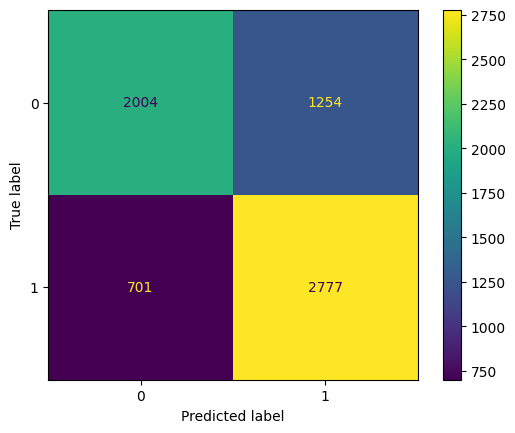

In [16]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = [0, 1])
cm_display.plot()
plt.show()

## Graph of the loss witnessed

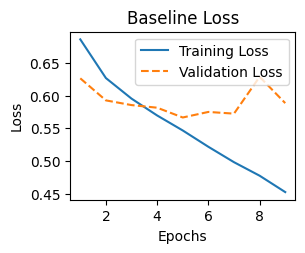

In [6]:
#using results obtained from training
train_loss = np.array([0.6864, 0.6271, 0.5956, 0.5698, 0.5468, 0.5218, 0.4982, 0.4775, 0.4524])
val_loss = np.array([0.6267, 0.5929, 0.5857, 0.5817, 0.5667, 0.5752, 0.5726, 0.629, 0.5887])
epochs_array = np.array([i for i in range(1,10)])

plt.subplot(2,2,2)
plt.plot(epochs_array, train_loss, label = "Training Loss")
plt.plot(epochs_array, val_loss, label = "Validation Loss", ls="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Baseline Loss")
plt.legend()

In [ ]:
#Best Standard = 0.6646
#Best ESIM = 0.7006
#Best ESIM bayes opt = 0.69
#ESIM self attention = 0.68
# Validation Accuracy:  0.7097684085510689
# Validation AUC:  0.7841427003587578
# Validation Precision:  0.714880608738836
# Validation Recall:  0.7067743363441024
# Validation F1:  0.7058953259666019
# Validation MCC:  0.4215770167605893
# Validation Loss:  0.5887175898698834